# 감정분석

In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
import numpy as np
import matplotlib.pyplot as plt

import os
import re
import shutil
import string

In [3]:
print(tf.__version__)

2.12.0


## 데이터세트 다운로드 및 탐색하기

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [5]:
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

84125825/84125825 [==============================] - 37s 0us/step


In [6]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(dataset_dir)

./aclImdb


In [7]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')

In [9]:
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [10]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## 데이터세트 로드하기

In [11]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [12]:
batch_size = 32
seed = 42

In [13]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', 
                                                          batch_size=batch_size, 
                                                          validation_split=0.2, 
                                                          subset='training', 
                                                          seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [14]:
# validation_split 및 subset 인수를 사용할 때 검증 및 훈련 분할이 겹치지 않도록 
# 임의 시드를 지정하거나 shuffle=False를 전달하는 것을 잊지 마세요.
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                        batch_size=batch_size, 
                                                        validation_split=0.2, 
                                                        subset='validation', 
                                                        seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test',
                                                        batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [16]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Lable", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Lable 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [17]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


## 훈련을 위한 데이터세트 준비하기

`tf.keras.layers.TextVectorization` 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화
- 표준화 : 일반적으로 구두점이나 HTML 요소를 제거하여 데이터세트를 단순화하기 위해 텍스트를 전처리하는 것
     - `<br />`와 같은 다양한 HTML 태그는 TextVectorization 레이어의 기본 표준화 도구로 제거되지 않음
     - 텍스트를 소문자로 변환하고 기본적으로 구두점을 제거하지만 HTML은 제거하지 않음
- 토큰화 : 문자열을 여러 토큰으로 분할하는 것(예: 화이트스페이스에서 분할하여 문장을 개별 단어로 분할)
- 벡터화 : 토큰을 숫자로 변환하여 신경망에 공급될 수 있도록 하는 것

In [18]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', '')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [19]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


- 각 토큰에 대해 고유한 정수 인덱스를 생성하도록 output_mode를 int로 설정
    - 각 토큰이 정수로 대체되며 `.get_vocabulary()` 를 통하여 해당토큰 조회 가능
- 기본 분할 함수와 위에서 정의한 사용자 지정 표준화 함수를 사용
- 명시적 최대값인 sequence_length와 같이 모델에 대한 몇 가지 상수를 정의하여 레이어가 시퀀스를 정확히 sequence_length 값으로 채우거나 자르도록 설정

In [20]:
max_features = 10000
sequence_length = 250

In [21]:
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization, 
    max_tokens=max_features, 
    output_mode='int', 
    output_sequence_length=sequence_length
)

In [22]:
train_text = raw_test_ds.map(lambda x, y : x)

In [23]:
vectorize_layer.adapt(data=train_text)

In [24]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [25]:
text_batch, label_batch = next(iter(raw_train_ds))

In [26]:
first_review, first_label = text_batch[0], label_batch[0]

In [27]:
print("Review", first_review)

Review tf.Tensor(b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up.", shape=(), dtype=string)


In [28]:
print("Label", raw_train_ds.class_names[first_label])

Label pos


In [29]:
print("Vectorized Reveiw", vectorize_text(first_review, first_label))

Vectorized Reveiw (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 265,  105,   86,    5,    1,    1,   94,   10,   66,  126,   12,
          11,    7,   24,  117,   19,    6, 1333,    4,    2,   86, 1786,
          29,    3, 2228, 2445,  833,  409,    1,  367,    5,    1, 1781,
        1665,  114,    2, 1329,    5,   33, 2471,    1,  367,    5, 9856,
           4,    1,  289,   14,  189,    3,  171,   14,   98,    5,    2,
          97,    2,  224,    7,  824,    2,   68,    7, 2851,    4,  418,
           4,    2,  290, 1805,    7,    1,  864, 1163, 3700, 5668,   43,
          22,   74,   96, 1155,   20,  253,    4, 1696,    7,    1,    6,
          75,  120,    1,   20,   56,   44,   21,  760,    2,  345, 1080,
           1,    8, 1944,  941,   37,   10,   79,   44,   21,   66,  157,
           9,   88, 1302,    9,   53,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  

In [30]:
print("117 --> ", vectorize_layer.get_vocabulary()[117])
print("3700 --> ", vectorize_layer.get_vocabulary()[3700])
print("5668 --> ", vectorize_layer.get_vocabulary()[5668])

117 -->  best
3700 -->  burning
5668 -->  paradise


In [31]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## 성능을 높이도록 데이터세트 구성하기

- `.cache()` :  데이터가 디스크에서 로드된 후 메모리에 데이터를 보관
    - 모델을 훈련하는 동안 데이터세트로 인해 병목 현상이 발생하지 않음
    - 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 뛰어난 온 디스크 캐시를 생성 필요
    - 많은 작은 파일보다 읽기가 더 효율적
- `.prefetch()` :  훈련 중에 데이터 전처리 및 모델 실행과 겹침

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

In [33]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델 생성

In [34]:
embedding_dims = 16

분류기(classifier)
- Layer 1:  Embedding
    - 정수로 인코딩된 리뷰를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾음
    - 이러한 벡터는 모델이 훈련되면서 학습됨
    - 이들 벡터는 출력 배열에 차원을 추가 : 최종 차원은 (batch, sequence, embedding)
- Layer 2: GlobalAveragePooling1D
    - sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환
    - 이는 길이가 다른 입력을 다루는 가장 간단한 방법
    - 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(Dense)을 거침
- Layer 3: 1개의 출력 노드(node)를 가진 완전 연결 층
    - sigmoid 활성화 함수를 사용하여 0과 1 사이의 실수를 출력
    - 이 값은 확률 또는 신뢰도를 나타냄

In [35]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dims),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

- 손실 함수(loss function) : 이진분류 문제이므로 sigmoid 사용
- 옵티마이저(optimizer): binary_crossentropy

## 손실함수와 옵티마이저

In [37]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.0))

## 모델 훈련하기

In [38]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 5s 6ms/step - loss: 0.6661 - binary_accuracy: 0.6836 - val_loss: 0.6205 - val_binary_accuracy: 0.7620
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5572 - binary_accuracy: 0.7908 - val_loss: 0.5086 - val_binary_accuracy: 0.8158
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4553 - binary_accuracy: 0.8378 - val_loss: 0.4310 - val_binary_accuracy: 0.8428
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3894 - binary_accuracy: 0.8611 - val_loss: 0.3842 - val_binary_accuracy: 0.8584
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3463 - binary_accuracy: 0.8749 - val_loss: 0.3550 - val_binary_accuracy: 0.8642
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3154 - binary_accuracy: 0.8859 - val_loss: 0.3356 - val_binary_accuracy: 0.8668
Epoch 7/10
625/625 [==============================] - 3s 4ms/ste

## 모델 평가하기

In [39]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 2s 2ms/step - loss: 0.3130 - binary_accuracy: 0.8724


In [40]:
print(f"Loss: {loss}")
print(f'Accuracy: {accuracy}')

Loss: 0.3129774332046509
Accuracy: 0.8723999857902527


## 정확도와 손실 그래프 그리기

In [41]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [42]:
train_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

In [43]:
epochs = range(1, len(train_accuracy) + 1)

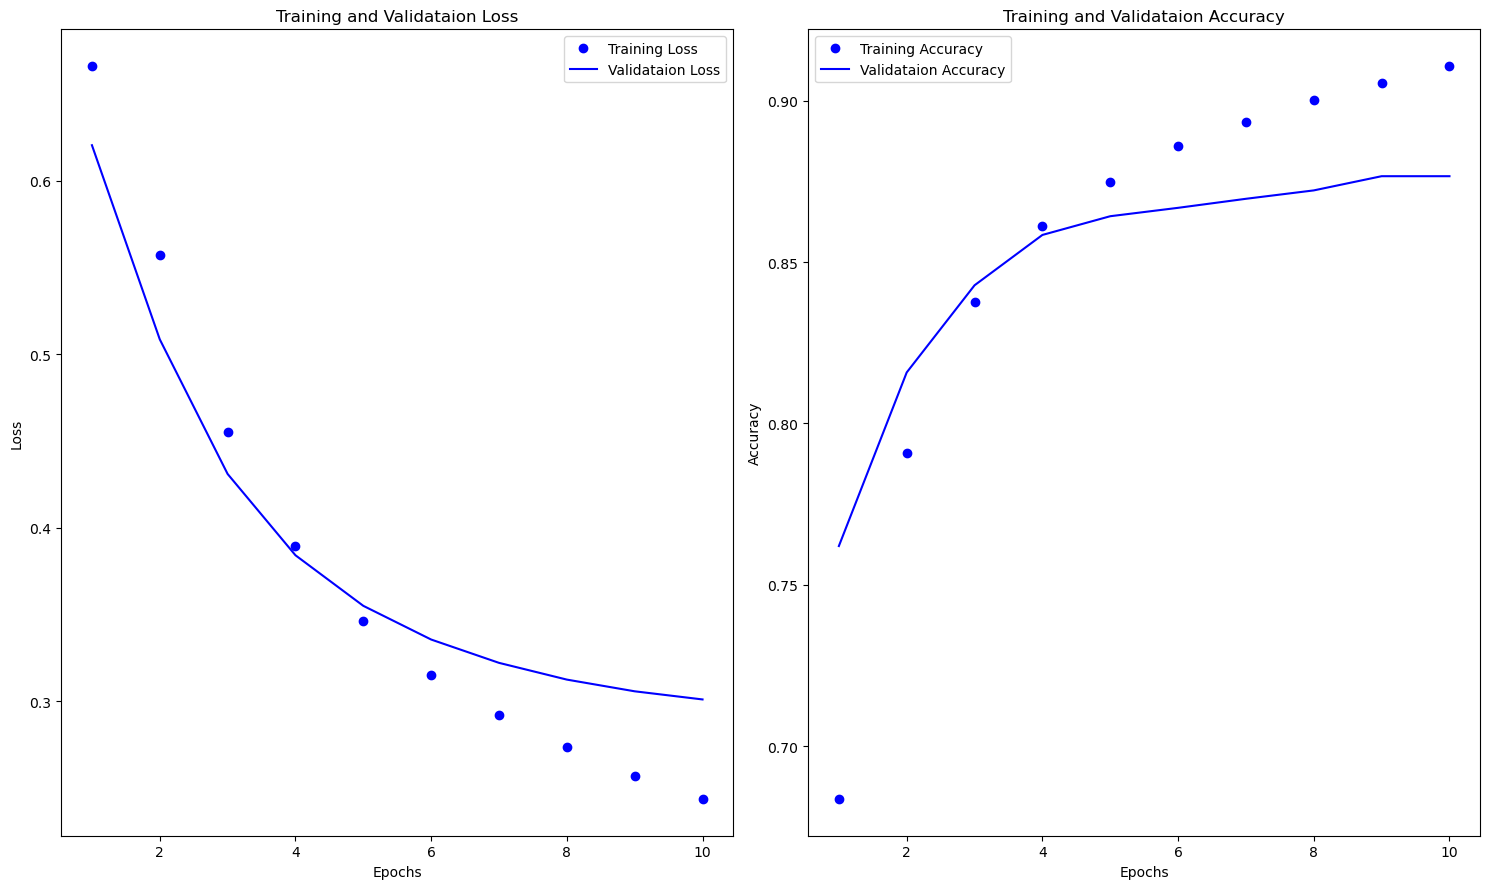

In [44]:
plt.figure(figsize=(15,9))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validataion Loss')
plt.title('Training and Validataion Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label = 'Validataion Accuracy')
plt.title('Training and Validataion Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 모델 내보내기

TextVectorization 레이어를 적용할 위치를 선택할 때 
- 레이어를 모델 외부에서 사용하면 GPU에서 훈련할 때 비동기 CPU 처리 및 데이터 버퍼링을 수행 가능
- 따라서 GPU에서 모델을 훈련하는 경우 모델을 개발하는 동안 최상의 성능을 얻기 위해 이 옵션을 사용하고 
- 배포 준비가 완료되면 모델 내부에 TextVectorization 레이어를 포함하도록 전환

In [45]:
export_model = tf.keras.models.Sequential([
    vectorize_layer, 
    model, 
    layers.Activation(activation='sigmoid')])

In [46]:
export_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 1)                 160033    
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [47]:
export_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                    optimizer='adam',
                    metrics=['accuracy'])

In [48]:
loss, accuracy = export_model.evaluate(raw_test_ds)

782/782 [==============================] - 3s 4ms/step - loss: 0.3130 - accuracy: 0.8724


In [49]:
print(f"Loss: {loss}")
print(f'Accuracy: {accuracy}')

Loss: 0.31297725439071655
Accuracy: 0.8723999857902527


## 새로운 데이터로 추론하기

In [50]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

In [51]:
export_model.predict(examples)

1/1 [==============================] - 0s 151ms/step


array([[0.630956  ],
       [0.45192653],
       [0.37612152]], dtype=float32)

# 연습 - Stack Overflow 질문에 대한 다중 클래스 분류